In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import scipy.ndimage
import skimage.io
import skimage.color
import skimage.transform
import cv2 as cv
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Dataset

In [3]:
data = fetch_openml("mnist_784")
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target.astype(int),
                                                    test_size=10000, train_size=60000,
                                                    random_state=10)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Distances

In [3]:
def euclidean_distance(x, y):
    sqr_x = np.sum(x**2, axis=1)
    sqr_y = np.sum(y**2, axis=1)
    temp_xy = np.dot(x, y.T)
    return np.sqrt(sqr_x[:, np.newaxis] + sqr_y - 2 * temp_xy)


def cosine_distance(x, y):
    return (1 - np.dot(x, y.T) /
            (np.sqrt(np.sum(x[:, np.newaxis, :] ** 2, axis=-1)) *
             np.sqrt(np.sum(y[np.newaxis, :, :] ** 2, axis=-1))))

## Nearest_neighbors

In [4]:
from sklearn.neighbors import NearestNeighbors


class KNNClassifier:
    def __init__(self, k, strategy, metric, weights, test_block_size):
        self.y = None
        self.k = k
        self.strategy = strategy
        if metric == 'euclidean':
            self.metric = euclidean_distance
        else:
            self.metric = cosine_distance
        self.weights = weights
        self.test_block_size = test_block_size
        if strategy != 'my_own':
            self.model = NearestNeighbors(n_neighbors=k,
                                          algorithm=strategy,
                                          metric=metric)
        else:
            self.X = None

    def fit(self, X, y):
        if self.strategy == 'my_own':
            self.X = X
        else:
            self.model.fit(X)
        self.y = y

    def find_kneighbors(self, X, return_distance):
        if self.strategy == 'my_own':
            temp = self.metric(self.X, X).T
            indices = np.argsort(temp, axis=1)[:, :self.k]
            if return_distance:
                distances = temp[np.arange(temp.shape[0])[:, None], indices]
                return distances, indices
            return indices
        return self.model.kneighbors(X, n_neighbors=self.k,
                                     return_distance=return_distance)

    def predict(self, X):
        def func(x):
            return np.argmax(np.bincount(x))
        ans = np.zeros(X.shape[0], dtype=self.y.dtype)
        for start in range(0, X.shape[0], self.test_block_size):
            end = min(start + self.test_block_size, X.shape[0])
            X_temp = X[start:end]
            if not self.weights:
                indices = self.find_kneighbors(X_temp,
                                               return_distance=False)
                temp = self.y[indices]
                ans[start:end] = np.apply_along_axis(func, 1, temp)
            else:
                distances, indices = self.find_kneighbors(X_temp,
                                                          return_distance=True)
                weights = 1 / (distances + 10 ** (-5))
                temp = self.y[indices]
                for i in range(temp.shape[0]):
                    label, label_idx = np.unique(temp[i], return_inverse=True)
                    label_idx = np.bincount(label_idx, weights=weights[i])
                    ans[start + i] = label[np.argmax(label_idx)]
        return ans

## Cross-validation

In [5]:
np.int = int


def kfold(n, n_folds):
    length = n // n_folds
    delta = n % n_folds
    indices = []
    for i in range(1, n_folds, 1):
        if i <= delta:
            indices.append(i * length + i)
        else:
            indices.append(i * length + delta)
    val = np.arange(0, indices[0])
    train = np.arange(indices[0], n)
    ans = [(train, val)]
    for i in range(len(indices) - 1):
        val = np.arange(indices[i], indices[i+1])
        train = np.array([j for j in range(n)
                          if ((j < indices[i]) or (j >= indices[i+1]))])
        ans.append((train, val))
    val = np.arange(indices[len(indices) - 1], n)
    train = np.arange(0, indices[len(indices) - 1])
    ans.append((train, val))
    return ans


def accuracy(y1, y2):
    return np.sum(y1 == y2) / y1.size


def knn_cross_val_score(X, y, k_list, score, cv, **kwargs):
    ans = {}
    if cv is None:
        cv = kfold(y.size, 3)
    for k in k_list:
        ans[k] = []
        model = KNNClassifier(k, **kwargs)
        for (train_index, val_index) in cv:
            X_train = X[train_index]
            y_train = y[train_index]
            X_val = X[val_index]
            y_val = y[val_index]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            if score == 'accuracy':
                ans[k].append(accuracy(y_val, y_pred))
        ans[k] = np.array(ans[k])
    return ans
    


# ЭКСПЕРИМЕНТЫ

### Эксперимент 1

Исследуйте, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях и почему.
Измерьте для каждого алгоритма поиска ('kd_tree', 'ball_tree', 'brute' и 'my_own') время нахождения 5 ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмноже- ство признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков выбирается один раз для всех объектов, случайно). Проверьте все алгоритмы поиска ближайших соседей, указанные в спецификации к заданию.

In [6]:
import time

def timed(model, X):
    time_start = time.time()
    result = model.find_kneighbors(X, return_distance=False)
    time_end = time.time()
    return time_end - time_start

In [7]:
n = X_train.shape[1]
features_10 = np.random.choice(n, 10, replace=False)
features_20 = np.random.choice(n, 20, replace=False)
features_100 = np.random.choice(n, 100, replace=False)

In [8]:
ans = {}
for name in ['kd_tree', 'ball_tree', 'brute', 'my_own']:
  print(name)
  model = KNNClassifier(k=5, strategy=name, metric='euclidean', weights=False, test_block_size=1000)
  ans[name] = []
  for features in [features_10, features_20, features_100]:
    model.fit(X_train[:, features], y_train)
    time_of_test = timed(model, X_test[:, features])
    ans[name].append(time_of_test)
    print(len(features), "признаков:", time_of_test)
  print()

kd_tree
10 признаков: 0.9145629405975342
20 признаков: 1.6279430389404297
100 признаков: 58.55842304229736

ball_tree
10 признаков: 1.83268404006958
20 признаков: 5.126328945159912
100 признаков: 59.63986611366272

brute
10 признаков: 6.851786851882935
20 признаков: 6.9868481159210205
100 признаков: 7.496880769729614

my_own
10 признаков: 46.464444160461426
20 признаков: 51.32782602310181
100 признаков: 75.20972800254822



In [11]:
ans

{'kd_tree': [0.9145629405975342, 1.6279430389404297, 58.55842304229736],
 'ball_tree': [1.83268404006958, 5.126328945159912, 59.63986611366272],
 'brute': [6.851786851882935, 6.9868481159210205, 7.496880769729614],
 'my_own': [46.464444160461426, 51.32782602310181, 75.20972800254822]}

### Эксперимент 2

Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) и время работы k ближайших соседей в зависимости от следующих факторов:

(a) k от 1 до 10 (только влияние на точность).

(b) Используется евклидова или косинусная метрика.


Дайте ответ на следующие вопросы:

(a) Какая метрика лучше себя показала в экспериментах? Можете ли вы объяснить, почему?


(b) Есть ли на графике зависимости точности от количество соседей выбросы, резкие падения/повышения качества для одного значения k по сравнению с соседними? Если да, предположите причину появления этих выбросов.

In [33]:
def knn_cross_val_score_and_time(X, y, k_list, score, cv, **kwargs):
    def accuracy(y1, y2):
        return np.sum(y1 == y2) / y1.size
    ans = {}
    time_of_tests = {}
    if cv is None:
        cv = kfold(y.size, 3)
    for k in k_list:
        print(f'k={k}')
        ans[k] = []
        time_of_tests[k] = []
        model = KNNClassifier(k, **kwargs)
        for (train_index, val_index) in cv:
            X_train = X[train_index]
            y_train = y[train_index]
            X_val = X[val_index]
            y_val = y[val_index]
            time_start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            time_end = time.time()
            time_of_tests[k].append(time_end - time_start)
            if score == 'accuracy':
                acc = accuracy(y_val, y_pred)
                ans[k].append(acc)
            print(f"accuracy={acc:.5f}  time={time_end - time_start:.5f}")
        ans[k].append(np.mean(ans[k]))
        ans[k] = np.array(ans[k])
        time_of_tests[k].append(np.mean(time_of_tests[k]))
        time_of_tests[k] = np.array(time_of_tests[k])
        print(f"mean_accuracy={ans[k][3]:.5f}   mean_time={time_of_tests[k][3]:.5f}")
        print()
    return ans, time_of_tests
    

In [117]:
print('euclidean - brute')
acc_euclidean_brute, time_euclidean_brute = knn_cross_val_score_and_time(X=X_train, y=y_train,
                                                                         k_list=list(range(1, 11, 1)),
                                                                         score='accuracy',
                                                                         cv=kfold(X_train.shape[0], 3), 
                                                                         strategy='brute',
                                                                         metric='euclidean',
                                                                         weights=False,
                                                                         test_block_size=1000)

euclidean - brute
k=1
accuracy=0.96935  time=14.37317
accuracy=0.96800  time=14.39176
accuracy=0.96920  time=15.24720
mean_accuracy=0.96885   mean_time=14.67071

k=2
accuracy=0.96285  time=19.31227
accuracy=0.95995  time=19.40478
accuracy=0.96300  time=19.52594
mean_accuracy=0.96193   mean_time=19.41433

k=3
accuracy=0.96875  time=23.18582
accuracy=0.96750  time=23.23016
accuracy=0.96945  time=23.15676
mean_accuracy=0.96857   mean_time=23.19091

k=4
accuracy=0.96775  time=17.98320
accuracy=0.96595  time=17.37540
accuracy=0.96705  time=16.03388
mean_accuracy=0.96692   mean_time=17.13083

k=5
accuracy=0.96815  time=18.32194
accuracy=0.96670  time=16.13744
accuracy=0.96775  time=16.36581
mean_accuracy=0.96753   mean_time=16.94173

k=6
accuracy=0.96705  time=19.56832
accuracy=0.96525  time=16.72078
accuracy=0.96720  time=16.41639
mean_accuracy=0.96650   mean_time=17.56850

k=7
accuracy=0.96660  time=19.02477
accuracy=0.96540  time=15.57085
accuracy=0.96640  time=14.41889
mean_accuracy=0.96

In [118]:
print('cosine - brute')
acc_cosine_brute, time_cosine_brute = knn_cross_val_score_and_time(X=X_train, y=y_train,
                                                                         k_list=list(range(1, 11, 1)),
                                                                         score='accuracy',
                                                                         cv=kfold(X_train.shape[0], 3), 
                                                                         strategy='brute',
                                                                         metric='cosine',
                                                                         weights=False,
                                                                         test_block_size=1000)

cosine - brute
k=1
accuracy=0.97325  time=15.00470
accuracy=0.97385  time=15.13688
accuracy=0.97210  time=15.72082
mean_accuracy=0.97307   mean_time=15.28747

k=2
accuracy=0.96960  time=19.57402
accuracy=0.97005  time=19.44940
accuracy=0.96815  time=19.54881
mean_accuracy=0.96927   mean_time=19.52408

k=3
accuracy=0.97480  time=23.28968
accuracy=0.97385  time=23.36253
accuracy=0.97290  time=23.30603
mean_accuracy=0.97385   mean_time=23.31942

k=4
accuracy=0.97275  time=17.97099
accuracy=0.97370  time=17.64807
accuracy=0.97210  time=17.43780
mean_accuracy=0.97285   mean_time=17.68562

k=5
accuracy=0.97255  time=18.07905
accuracy=0.97355  time=17.70105
accuracy=0.97155  time=17.44627
mean_accuracy=0.97255   mean_time=17.74212

k=6
accuracy=0.97205  time=18.17531
accuracy=0.97275  time=18.07512
accuracy=0.97135  time=17.91148
mean_accuracy=0.97205   mean_time=18.05397

k=7
accuracy=0.97115  time=18.19184
accuracy=0.97200  time=17.42667
accuracy=0.96945  time=17.18444
mean_accuracy=0.97087

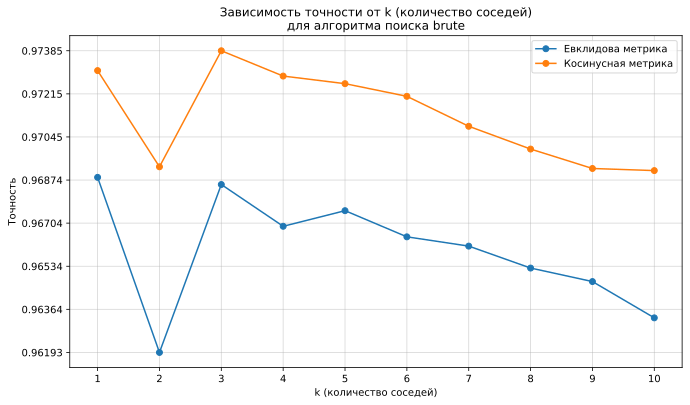

In [183]:
fig, ax = plt.subplots(figsize=(11, 6))
plt.grid(True, alpha=0.5)
plt.title("Зависимость точности от k (количество соседей)\nдля алгоритма поиска brute")
plt.xlabel("k (количество соседей)")
plt.ylabel("Точность")

k_list = list(range(1, 11, 1))

accuracy_euclidean = []
accuracy_cosine = []
for k in k_list:
    accuracy_euclidean.append(acc_euclidean_brute[k][3])
for k in k_list:
    accuracy_cosine.append(acc_cosine_brute[k][3])

ticks_for_y = np.linspace(min(min(accuracy_euclidean), min(accuracy_cosine)), 
                          max(max(accuracy_euclidean), max(accuracy_cosine)), 8)
ax.set_yticks(ticks_for_y)
ax.set_xticks(k_list)

plt.plot(k_list, accuracy_euclidean, marker='o', label='Евклидова метрика')
plt.plot(k_list, accuracy_cosine, marker='o', label='Косинусная метрика')

ax.legend(loc='upper right')
plt.savefig('ex2_a.pdf', format='pdf')
plt.show()

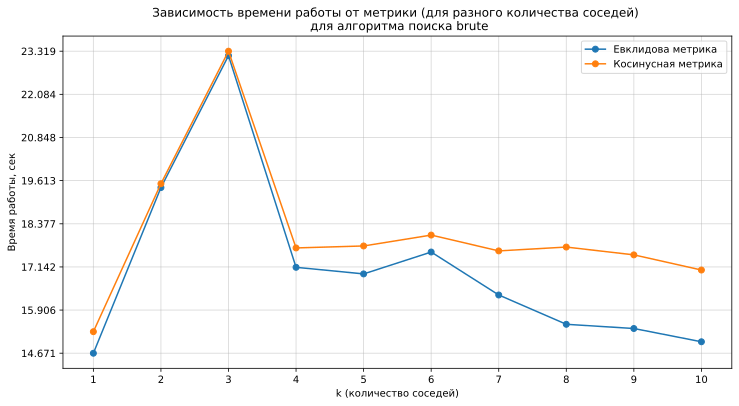

In [182]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True, alpha=0.5)
plt.title("Зависимость времени работы от метрики (для разного количества соседей) \n для алгоритма поиска brute")
plt.xlabel("k (количество соседей)")
plt.ylabel("Время работы, сек")

time_euclidean = []
time_cosine = []
for k in k_list:
    time_euclidean.append(time_euclidean_brute[k][3])
for k in k_list:
    time_cosine.append(time_cosine_brute[k][3])

ticks_for_y = np.linspace(min(min(time_euclidean), min(time_cosine)), 
                          max(max(time_euclidean), max(time_cosine)), 8)
ax.set_yticks(ticks_for_y)
k_list = list(range(1, 11, 1))
ax.set_xticks(k_list)

plt.plot(k_list, time_euclidean, marker='o', label='Евклидова метрика')
plt.plot(k_list, time_cosine, marker='o', label='Косинусная метрика')

ax.legend(loc='best')
plt.savefig('ex2_b.pdf', format='pdf')
plt.show()

### Эксперимент 3

Сравните взвешенный метод k ближайших соседей, где голос объекта равен 1/(distance + ε), где ε — 10−5, с методом без весов при тех же фолдах и параметрах.

In [135]:
print('euclidean - brute - weights')
acc_euclidean_brute_weights, time_euclidean_brute_weights = knn_cross_val_score_and_time(X=X_train, y=y_train,
                                                                         k_list=list(range(1, 11, 1)),
                                                                         score='accuracy',
                                                                         cv=kfold(X_train.shape[0], 3), 
                                                                         strategy='brute',
                                                                         metric='euclidean',
                                                                         weights=True,
                                                                         test_block_size=1000)

euclidean - brute - weights
k=1
accuracy=0.96935  time=13.65141
accuracy=0.96800  time=13.58723
accuracy=0.96920  time=13.64716
mean_accuracy=0.96885   mean_time=13.62860

k=2
accuracy=0.96935  time=17.58418
accuracy=0.96800  time=17.63299
accuracy=0.96920  time=17.65230
mean_accuracy=0.96885   mean_time=17.62316

k=3
accuracy=0.97005  time=21.33552
accuracy=0.96830  time=21.48493
accuracy=0.97055  time=21.94290
mean_accuracy=0.96963   mean_time=21.58778

k=4
accuracy=0.97175  time=17.75804
accuracy=0.96975  time=15.70794
accuracy=0.97060  time=15.95367
mean_accuracy=0.97070   mean_time=16.47322

k=5
accuracy=0.96980  time=16.05340
accuracy=0.96765  time=15.18758
accuracy=0.96905  time=15.06567
mean_accuracy=0.96883   mean_time=15.43555

k=6
accuracy=0.97000  time=16.33205
accuracy=0.96845  time=15.56619
accuracy=0.96970  time=14.75452
mean_accuracy=0.96938   mean_time=15.55092

k=7
accuracy=0.96810  time=16.39827
accuracy=0.96700  time=15.15969
accuracy=0.96710  time=15.02752
mean_acc

In [136]:
print('euclidean - cosine - weights')
acc_cosine_brute_weights, time_cosine_brute_weights = knn_cross_val_score_and_time(X=X_train, y=y_train,
                                                                         k_list=list(range(1, 11, 1)),
                                                                         score='accuracy',
                                                                         cv=kfold(X_train.shape[0], 3), 
                                                                         strategy='brute',
                                                                         metric='cosine',
                                                                         weights=True,
                                                                         test_block_size=1000)

euclidean - cosine - weights
k=1
accuracy=0.97325  time=15.58460
accuracy=0.97385  time=15.82184
accuracy=0.97210  time=15.45121
mean_accuracy=0.97307   mean_time=15.61921

k=2
accuracy=0.97325  time=18.99929
accuracy=0.97385  time=18.89558
accuracy=0.97210  time=19.21697
mean_accuracy=0.97307   mean_time=19.03728

k=3
accuracy=0.97515  time=23.03607
accuracy=0.97535  time=25.19685
accuracy=0.97355  time=26.98469
mean_accuracy=0.97468   mean_time=25.07254

k=4
accuracy=0.97560  time=19.69933
accuracy=0.97595  time=17.67375
accuracy=0.97455  time=17.22254
mean_accuracy=0.97537   mean_time=18.19854

k=5
accuracy=0.97305  time=17.75952
accuracy=0.97445  time=19.06727
accuracy=0.97285  time=19.80284
mean_accuracy=0.97345   mean_time=18.87654

k=6
accuracy=0.97405  time=18.24645
accuracy=0.97485  time=17.97382
accuracy=0.97370  time=17.73314
mean_accuracy=0.97420   mean_time=17.98447

k=7
accuracy=0.97140  time=18.00008
accuracy=0.97300  time=17.94010
accuracy=0.97085  time=17.14744
mean_ac

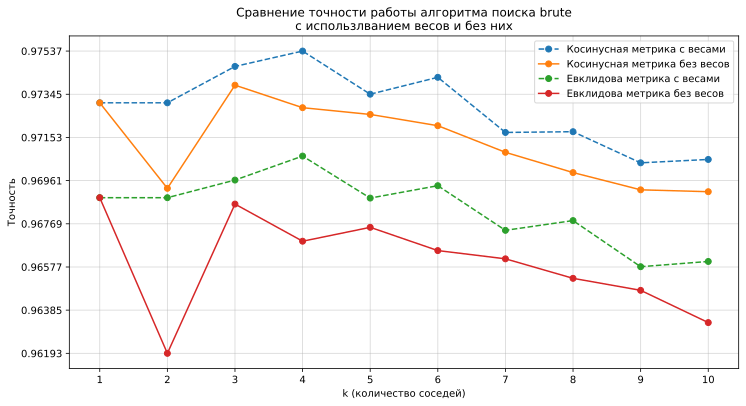

In [184]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True, alpha=0.5)
plt.title("Cравнение точности работы алгоритма поиска brute\nc использлванием весов и без них")
plt.xlabel("k (количество соседей)")
plt.ylabel("Точность")

accuracy_euclidean_weights = []
accuracy_cosine_weights  = []
for k in k_list:
    accuracy_euclidean_weights.append(acc_euclidean_brute_weights[k][3])
for k in k_list:
    accuracy_cosine_weights .append(acc_cosine_brute_weights[k][3])


ticks_for_y = np.linspace(min(min(accuracy_euclidean), min(accuracy_cosine),
                              min(accuracy_euclidean_weights), min(accuracy_cosine_weights)),
                          max(max(accuracy_euclidean), max(accuracy_cosine),
                             max(accuracy_euclidean_weights), max(accuracy_cosine_weights)), 8)
ax.set_yticks(ticks_for_y)
k_list = list(range(1, 11, 1))
ax.set_xticks(k_list)

plt.plot(k_list, accuracy_cosine_weights, marker='o', label='Косинусная метрика с весами', ls='--')
plt.plot(k_list, accuracy_cosine, marker='o', label='Косинусная метрика без весов', ls='-')

plt.plot(k_list, accuracy_euclidean_weights, marker='o', label='Евклидова метрика c весами', ls='--')
plt.plot(k_list, accuracy_euclidean, marker='o', label='Евклидова метрика без весов', ls='-')

ax.legend(loc='upper right')
plt.savefig('ex3_1.pdf', format='pdf')
plt.show()

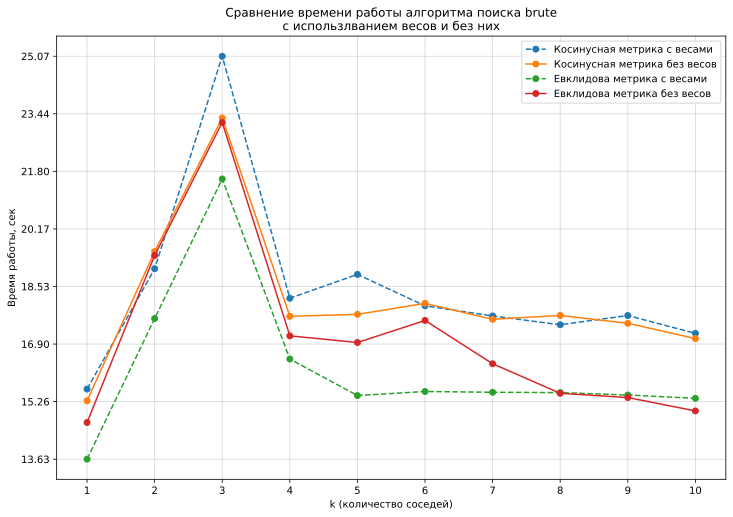

In [185]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(True, alpha=0.5)
plt.title("Cравнение времени работы алгоритма поиска brute\nc использлванием весов и без них")
plt.xlabel("k (количество соседей)")
plt.ylabel("Время работы, сек")

time_euclidean_weights = []
time_cosine_weights  = []
for k in k_list:
    time_euclidean_weights.append(time_euclidean_brute_weights[k][3])
for k in k_list:
    time_cosine_weights .append(time_cosine_brute_weights[k][3])


ticks_for_y = np.linspace(min(min(time_euclidean), min(time_cosine),
                              min(time_euclidean_weights), min(time_cosine_weights)),
                          max(max(time_euclidean), max(time_cosine),
                             max(time_euclidean_weights), max(time_cosine_weights)), 8)
ax.set_yticks(ticks_for_y)
k_list = list(range(1, 11, 1))
ax.set_xticks(k_list)

plt.plot(k_list, time_cosine_weights, marker='o', label='Косинусная метрика с весами', ls='--')
plt.plot(k_list, time_cosine, marker='o', label='Косинусная метрика без весов', ls='-')

plt.plot(k_list, time_euclidean_weights, marker='o', label='Евклидова метрика c весами', ls='--')
plt.plot(k_list, time_euclidean, marker='o', label='Евклидова метрика без весов', ls='-')

ax.legend(loc='upper right')
plt.savefig('ex3_2.pdf', format='pdf')
plt.show()

### Экспериемнт 4

Примените лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитайте точность. Сравните с точностью по кросс-валидации. Сравните с указанной в интернете точностью лучших алгоритмов на данной выборке. Выполните анализ ошибок. Для этого необходимо построить и проанализировать матрицу ошибок (confusion matrix). Также визуализируйте несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализируйте и указажите их общие черты.

In [131]:
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
acc_full_test = accuracy(y_pred_test, y_test)
acc_full_train = accuracy(y_pred_train, y_train)
print(f"Точность на тестовой выборки = {acc_full_test}")
print(f"Точность на тренировочной выборки = {acc_full_train}")

Точность на тестовой выборки = 0.9781
Точность на тренировочной выборки = 1.0


In [9]:
acc_val_3 = knn_cross_val_score(X=X_train, y=y_train, k_list=[4], 
                                   score='accuracy', cv=None,
                                   strategy='brute', metric='cosine', 
                                   weights=True, test_block_size=1000)

In [10]:
print(f"Точноcти на фолдах в кросс-валидация: {acc_val_3[4][0]}, {acc_val_3[4][1]}, {acc_val_3[4][2]}")
print(f"Средняя точность по кросс-валидации: {np.mean(acc_val_3[4]):.4f}")

Точноcти на фолдах в кросс-валидация: 0.9756, 0.97595, 0.97455
Средняя точность по кросс-валидации: 0.9754


In [11]:
print(f"Лучшая точность алгоритмов на данной выборке: {1 - 0.18/100}")

Лучшая точность алгоритмов на данной выборке: 0.9982


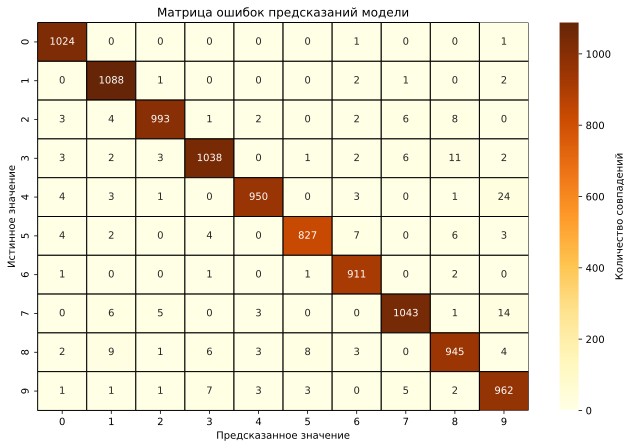

In [132]:
matrix_nopar = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(11, 7))
ax = sns.heatmap(matrix_nopar, cmap="YlOrBr", annot=True, fmt="g",
                 linewidths=1, linecolor='black',
                 cbar_kws={'label': 'Количество совпадений'})
plt.title('Матрица ошибок предсказаний модели')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказанное значение')
plt.savefig('ex4_mat.pdf', format='pdf')
plt.show()

In [61]:
index_of_err = []
for i in range (10):
    all_err = np.where((y_test == i) & (y_pred_test != i))[0]
    index_of_err.append(np.argmax(np.bincount(all_err)))

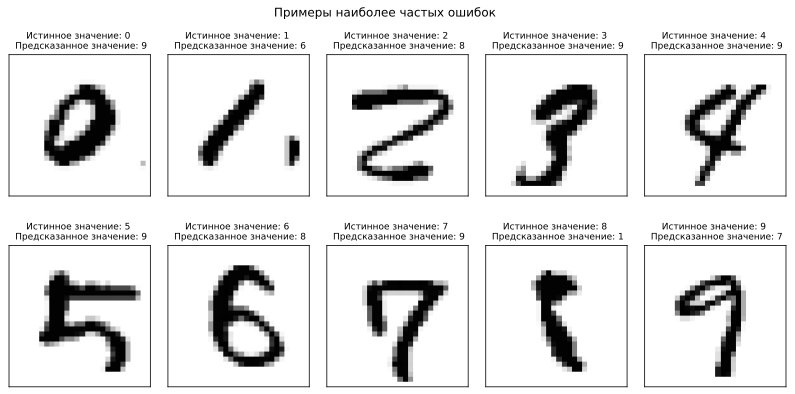

In [99]:
fig = plt.figure(figsize=(14, 6))
plt.suptitle("Примеры наиболее частых ошибок", y=0.99)
plt.axis("off") 
for i, index in enumerate(index_of_err):
    ax = plt.subplot(2, 5, i+1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.title(f"Истинное значение: {y_test[index]} \n Предсказанное значение: {y_pred_test[index]}", fontsize=9)
    plt.imshow(X_test[index].reshape(28,28), cmap='Greys')
plt.subplots_adjust(hspace = 0.35, wspace=0.1)
plt.savefig('ex4_err.pdf', format='pdf')
plt.show()


### Эксперимент 5

Выполните аугментацию обучающей выборки. Для этого нужно размножить ее с помощью поворотов, смещений, морфологических операций и применений гауссовского фильтра. Разрешается использовать библиотеки для работы с изображениями. Подберите по кросс-валидации с 3 фолдами параметры преоб- разований. Рассмотрите следующие параметры для преобразований и их комбинации:

(a) Величина поворота: 5, 10, 15 (в каждую из двух сторон)

(b) Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)

(c) Дисперсия фильтра Гаусса: 0.5, 1, 1.5

(d) Морфологические операции: эрозия, дилатация, открытие, закрытие с ядром 2

Проанализируйте, как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование.

#### Поворот

In [8]:
import random

def rotation(X, angle):
    def one_rotation(x):
        return skimage.transform.rotate(x.reshape(28,28), random.choice([1, -1]) * angle)
    shape_old = X.shape
    return np.apply_along_axis(one_rotation, 1, X).reshape(shape_old)

In [122]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)

for i in [5, 10, 15]:
    X_train_rotation = np.vstack((X_train, rotation(X_train, i)))
    y_train_rotation = np.hstack((y_train, y_train))
    
    X_train_rotation = X_train_rotation[indices]
    y_train_rotation = y_train_rotation[indices]
    acc_val_rotation = knn_cross_val_score(X=X_train_rotation, y=y_train_rotation, k_list=[4], 
                                   score='accuracy', cv=None,
                                   strategy='brute', metric='cosine', 
                                   weights=True, test_block_size=1000)
    print(f"Поворот на {i}")
    print(f"Средняя точность по кросс-валидации: {np.mean(acc_val_rotation[4])}")
    print()
    

Поворот на 5
Средняя точность по кросс-валидации: 0.851375

Поворот на 10
Средняя точность по кросс-валидации: 0.826575

Поворот на 15
Средняя точность по кросс-валидации: 0.80625



In [135]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_rotation = np.vstack((X_train, rotation(X_train, 5)))
y_train_rotation = np.hstack((y_train, y_train))
X_train_rotation = X_train_rotation[indices]
y_train_rotation = y_train_rotation[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_rotation, y_train_rotation)
y_pred_test_rotation = model.predict(X_test)

acc_full_test_rotation = accuracy(y_pred_test_rotation, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_rotation}")

Точность на тестовой выборки = 0.9781


In [167]:
matrix_rot = confusion_matrix(y_test, y_pred_test_rotation)

#### СМЕЩЕНИЕ

In [11]:
def shifted(X, pix):
    def one_shifted(x):
        rand_1 = random.choice([1, -1])
        rand_2 = random.choice([1, -1])
        return scipy.ndimage.shift(x.reshape(28,28), [pix * rand_1, pix * rand_2])
    shape_old = X.shape
    return np.apply_along_axis(one_shifted, 1, X).reshape(shape_old)

In [147]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)

for i in [1, 2, 3]:
    X_train_shifted = np.vstack((X_train, shifted(X_train, i)))
    y_train_shifted = np.hstack((y_train, y_train))
    
    X_train_shifted = X_train_shifted[indices]
    y_train_shifted = y_train_shifted[indices]
    acc_val_shifted = knn_cross_val_score(X=X_train_shifted, y=y_train_shifted, k_list=[4], 
                                   score='accuracy', cv=None,
                                   strategy='brute', metric='cosine', 
                                   weights=True, test_block_size=1000)
    print(f"Смещение на {i}")
    print(f"Средняя точность по кросс-валидации: {np.mean(acc_val_shifted[4])}")
    print()
    

Смещение на 1
Средняя точность по кросс-валидации: 0.9725416666666667

Смещение на 2
Средняя точность по кросс-валидации: 0.96805

Смещение на 3
Средняя точность по кросс-валидации: 0.9675416666666666



In [137]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_shifted = np.vstack((X_train, shifted(X_train, 1)))
y_train_shifted = np.hstack((y_train, y_train))
X_train_shifted = X_train_shifted[indices]
y_train_shifted = y_train_shifted[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_shifted, y_train_shifted)
y_pred_test_shifted = model.predict(X_test)

acc_full_test_shifted = accuracy(y_pred_test_shifted, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_shifted}")

Точность на тестовой выборки = 0.9803


In [166]:
matrix_sh = confusion_matrix(y_test, y_pred_test_shifted)

#### Дисперсия фильтра Гаусса

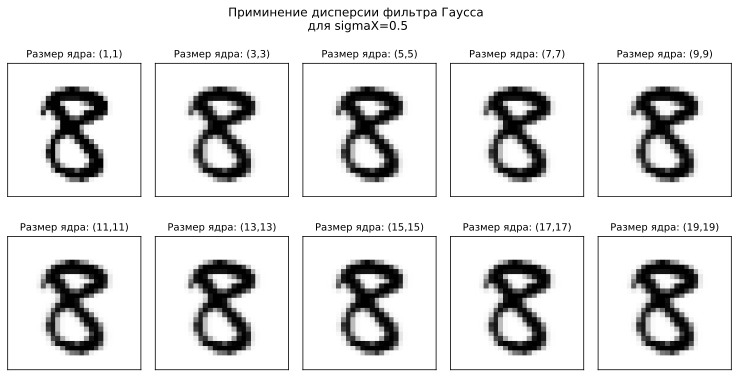

In [4]:
elem = X_train[1].astype(np.uint8)
fig = plt.figure(figsize=(13, 6))
plt.suptitle("Приминение дисперсии фильтра Гаусса \nдля sigmaX=0.5", y=0.95)
fig.subplots_adjust(top=0.82)
plt.axis("off") 
num = 1
for i in range (1, 20, 2):
    ax = plt.subplot(2, 5, num)
    num += 1
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    blured_elem = cv.GaussianBlur(elem, (i, i) , 0.5)
    plt.title(f"Размер ядра: ({i},{i})", fontsize=10)
    plt.imshow(blured_elem.reshape(28,28), cmap='Greys')
plt.subplots_adjust(hspace = 0.3, wspace=0.1)
plt.savefig('ex4_gaus_05.pdf', format='pdf')
plt.show()

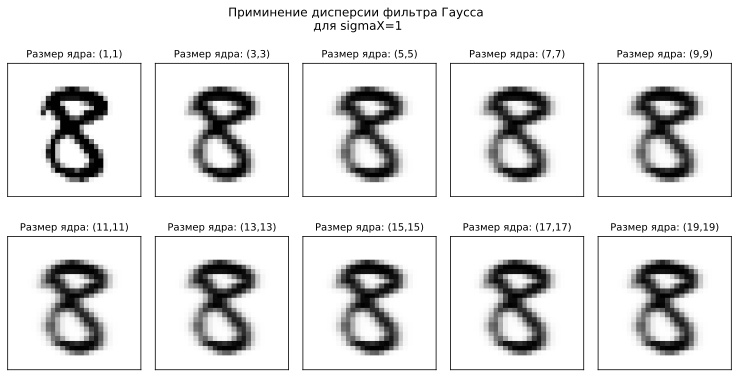

In [5]:
elem = X_train[1].astype(np.uint8)
fig = plt.figure(figsize=(13, 6))
plt.suptitle("Приминение дисперсии фильтра Гаусса \nдля sigmaX=1", y=0.95)
fig.subplots_adjust(top=0.82)
plt.axis("off") 
num = 1
for i in range (1, 20, 2):
    ax = plt.subplot(2, 5, num)
    num += 1
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    blured_elem = cv.GaussianBlur(elem, (i, i) , 1)
    plt.title(f"Размер ядра: ({i},{i})", fontsize=10)
    plt.imshow(blured_elem.reshape(28,28), cmap='Greys')
plt.subplots_adjust(hspace = 0.3, wspace=0.1)
plt.savefig('ex4_gaus_10.pdf', format='pdf')
plt.show()

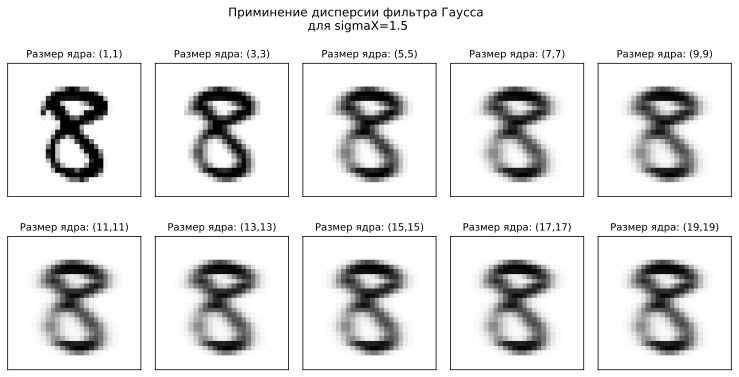

In [6]:
elem = X_train[1].astype(np.uint8)
fig = plt.figure(figsize=(13, 6))
plt.suptitle("Приминение дисперсии фильтра Гаусса \nдля sigmaX=1.5", y=0.95)
fig.subplots_adjust(top=0.82)
plt.axis("off") 
num = 1
for i in range (1, 20, 2):
    ax = plt.subplot(2, 5, num)
    num += 1
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    blured_elem = cv.GaussianBlur(elem, (i, i) , 1.5)
    plt.title(f"Размер ядра: ({i},{i})", fontsize=10)
    plt.imshow(blured_elem.reshape(28,28), cmap='Greys')
plt.subplots_adjust(hspace = 0.3, wspace=0.1)
plt.savefig('ex4_gaus_15.pdf', format='pdf')
plt.show()

In [17]:
def gaus(X, ker, sig):
    def one_gaus(x):
        return cv.GaussianBlur(x.astype(np.uint8), (ker, ker) , sig)
    shape_old = X.shape
    return np.apply_along_axis(one_gaus, 1, X).reshape(shape_old)

In [318]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)

for i in [0.5, 1, 1.5]:
    if i == 0.5:
        X_train_gaus = np.vstack((X_train, gaus(X_train, 7, 0.5)))
    elif i == 1:
        X_train_gaus = np.vstack((X_train, gaus(X_train, 9, 1)))
    else:
        X_train_gaus = np.vstack((X_train, gaus(X_train, 11, 1.5)))
        
    y_train_gaus = np.hstack((y_train, y_train))
    X_train_gaus = X_train_gaus[indices]
    y_train_gaus = y_train_gaus[indices]
    acc_val_gaus = knn_cross_val_score(X=X_train_gaus, y=y_train_gaus, k_list=[4], 
                                   score='accuracy', cv=None,
                                   strategy='brute', metric='cosine', 
                                   weights=True, test_block_size=1000)
    print(f"sigmaX = {i}")
    print(f"Средняя точность по кросс-валидации: {np.mean(acc_val_gaus[4])}")
    print()
    

sigmaX = 0.5
Средняя точность по кросс-валидации: 0.9918583333333334

sigmaX = 1
Средняя точность по кросс-валидации: 0.9913250000000001

sigmaX = 1.5
Средняя точность по кросс-валидации: 0.9863416666666667



In [139]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_gaus = np.vstack((X_train, gaus(X_train, 7, 0.5)))
y_train_gaus = np.hstack((y_train, y_train))
X_train_gaus = X_train_gaus[indices]
y_train_gaus = y_train_gaus[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_gaus, y_train_gaus)
y_pred_test_gaus = model.predict(X_test)

acc_full_test_gaus = accuracy(y_pred_test_gaus, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_gaus}")

Точность на тестовой выборки = 0.9764


In [165]:
matrix_dis = confusion_matrix(y_test, y_pred_test_gaus)

#### ЭРОЗИЯ

In [20]:
def erosion(X):
    def one_erosion(x):
        return cv.erode(x.astype(np.uint8), kernel, iterations = 1)
    shape_old = X.shape
    kernel = np.ones((2,2),np.uint8)
    return np.apply_along_axis(one_erosion, 1, X).reshape(shape_old)

In [141]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_erosion = np.vstack((X_train, erosion(X_train)))
y_train_erosion = np.hstack((y_train, y_train))
X_train_erosion = X_train_erosion[indices]
y_train_erosion = y_train_erosion[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_erosion, y_train_erosion)
y_pred_test_erosion = model.predict(X_test)

acc_full_test_erosion = accuracy(y_pred_test_erosion, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_erosion}")

Точность на тестовой выборки = 0.9779


In [164]:
matrix_er = confusion_matrix(y_test, y_pred_test_erosion)

#### ДИЛАТАЦИЯ

In [23]:
def dilation(X):
    def one_dilation(x):
        return cv.dilate(x.astype(np.uint8), kernel, iterations = 1)
    shape_old = X.shape
    kernel = np.ones((2,2),np.uint8)
    return np.apply_along_axis(one_dilation, 1, X).reshape(shape_old)

In [143]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_dilation = np.vstack((X_train, dilation(X_train)))
y_train_dilation = np.hstack((y_train, y_train))
X_train_dilation = X_train_dilation[indices]
y_train_dilation = y_train_dilation[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_dilation, y_train_dilation)
y_pred_test_dilation = model.predict(X_test)

acc_full_test_dilation = accuracy(y_pred_test_dilation, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_dilation}")

Точность на тестовой выборки = 0.9807


In [163]:
matrix_dil = confusion_matrix(y_test, y_pred_test_dilation)

#### ОТКРЫТИЕ

In [26]:
def opening(X):
    def one_opening(x):
        return cv.morphologyEx(x.astype(np.uint8), cv.MORPH_OPEN, kernel)
    shape_old = X.shape
    kernel = np.ones((2,2),np.uint8)
    return np.apply_along_axis(one_opening, 1, X).reshape(shape_old)

In [145]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_opening = np.vstack((X_train, opening(X_train)))
y_train_opening = np.hstack((y_train, y_train))
X_train_opening = X_train_opening[indices]
y_train_opening = y_train_opening[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_opening, y_train_opening)
y_pred_test_opening = model.predict(X_test)

acc_full_test_opening = accuracy(y_pred_test_opening, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_opening}")

Точность на тестовой выборки = 0.9796


In [162]:
matrix_op = confusion_matrix(y_test, y_pred_test_opening)

#### ЗАКРЫТИЕ

In [29]:
def closing(X):
    def one_closing(x):
        return cv.morphologyEx(x.astype(np.uint8), cv.MORPH_CLOSE, kernel)
    shape_old = X.shape
    kernel = np.ones((2,2),np.uint8)
    return np.apply_along_axis(one_closing, 1, X).reshape(shape_old)

In [147]:
indices = np.arange(X_train.shape[0] * 2)
np.random.shuffle(indices)
X_train_closing = np.vstack((X_train, closing(X_train)))
y_train_closing = np.hstack((y_train, y_train))
X_train_closing = X_train_closing[indices]
y_train_closing = y_train_closing[indices]

model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_closing, y_train_closing)
y_pred_test_closing = model.predict(X_test)

acc_full_test_closing = accuracy(y_pred_test_closing, y_test)
print(f"Точность на тестовой выборки = {acc_full_test_closing}")

Точность на тестовой выборки = 0.9795


In [161]:
matrix_cl = confusion_matrix(y_test, y_pred_test_closing)

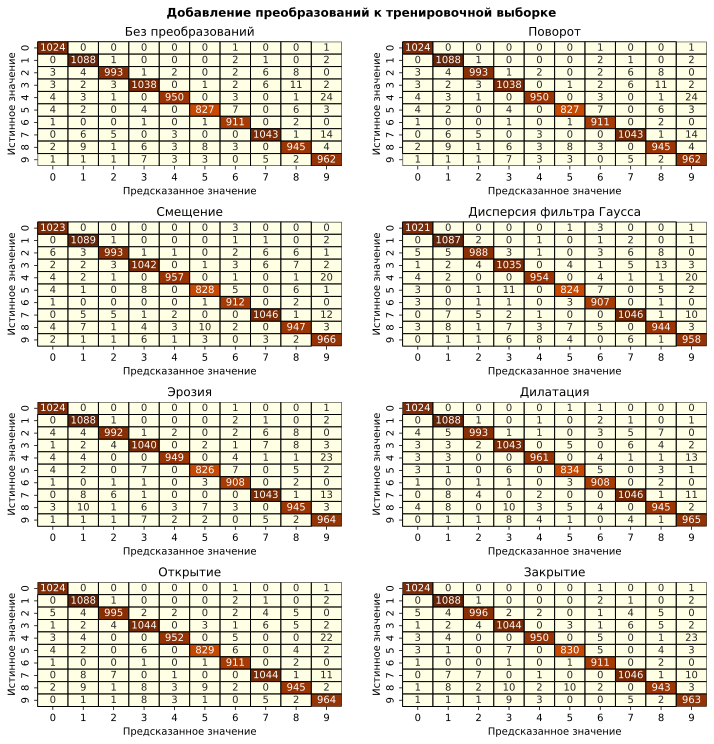

In [160]:
matr = [matrix_nopar, matrix_rot, matrix_sh, matrix_dis, matrix_er, matrix_dil, matrix_op, matrix_cl]
tit = ['Без преобразований', 'Поворот', 'Смещение', 'Дисперсия фильтра Гаусса', 'Эрозия', 'Дилатация', 'Открытие', 'Закрытие']
fig, axes = plt.subplots(4, 2, figsize=(12,12))
plt.suptitle("Добавление преобразований к тренировочной выборке", y=0.92, weight='bold')
for ax, m, t in zip(axes.flat, matr, tit):
    sns.heatmap(m, cmap="YlOrBr", annot=True, fmt="g", ax=ax,
                 linewidths=1, linecolor='black', cbar=False)
    ax.set_title(f'{t}')
    ax.set_ylabel('Истинное значение')
    ax.set_xlabel('Предсказанное значение')
plt.subplots_adjust(hspace = 0.45)
plt.savefig('ex5_preobr.pdf', format='pdf')
plt.show()

### КОМБИНАЦИИ

#### дилатация + смещение

* смещение + открытие

* дилатация + смещение

* дилатация + смещение + открытие

* дилатация + дисперсия + смещение


In [177]:
indices_3 = np.arange(X_train.shape[0] * 3)
indices_4 = np.arange(X_train.shape[0] * 4)

y_train_3 = np.hstack((y_train, y_train, y_train))
y_train_3 = y_train_3[indices_3]

y_train_4 = np.hstack((y_train_3, y_train))
y_train_4 = y_train_4[indices_4]

X_train_sh_op = np.vstack((X_train, shifted(X_train, 1), opening(X_train)))
X_train_sh_op = X_train_sh_op[indices_3]

X_train_dil_sh = np.vstack((X_train, dilation(X_train), shifted(X_train, 1)))
X_train_dil_sh = X_train_dil_sh[indices_3]

X_train_dil_sh_op = np.vstack((X_train, dilation(X_train), shifted(X_train, 1), opening(X_train)))
X_train_dil_sh_op = X_train_dil_sh_op[indices_4]

X_train_dil_dis_sh = np.vstack((X_train, dilation(X_train), gaus(X_train, 7, 0.5), shifted(X_train, 1)))
X_train_dil_dis_sh = X_train_dil_dis_sh[indices_4]

In [178]:
print('смещение + открытие')
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_sh_op, y_train_3)
y_pred_sh_op = model.predict(X_test)
acc_1 = accuracy(y_pred_sh_op, y_test)
print(f"Точность на тестовой выборки = {acc_1}")

matrix_sh_op = confusion_matrix(y_test, y_pred_sh_op)

смещение + открытие
Точность на тестовой выборки = 0.981


In [180]:
print('дилатация + смещение')
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_dil_sh, y_train_3)
y_pred_dil_sh = model.predict(X_test)
acc_2 = accuracy(y_pred_dil_sh, y_test)
print(f"Точность на тестовой выборки = {acc_2}")

matrix_dil_sh = confusion_matrix(y_test, y_pred_dil_sh)

дилатация + смещение
Точность на тестовой выборки = 0.9809


In [181]:
print('дилатация + смещение + открытие')
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_dil_sh_op, y_train_4)
y_pred_dil_sh_op = model.predict(X_test)
acc_3 = accuracy(y_pred_dil_sh_op, y_test)
print(f"Точность на тестовой выборки = {acc_3}")

matrix_dil_sh_op = confusion_matrix(y_test, y_pred_dil_sh_op)

дилатация + смещение + открытие
Точность на тестовой выборки = 0.9819


In [182]:
print('дилатация + дисперсия + смещение')
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train_dil_dis_sh, y_train_4)
y_pred_dil_dis_sh = model.predict(X_test)
acc_4 = accuracy(y_pred_dil_dis_sh, y_test)
print(f"Точность на тестовой выборки = {acc_4}")

matrix_dil_dis_sh = confusion_matrix(y_test, y_pred_dil_dis_sh)

дилатация + дисперсия + смещение
Точность на тестовой выборки = 0.9809


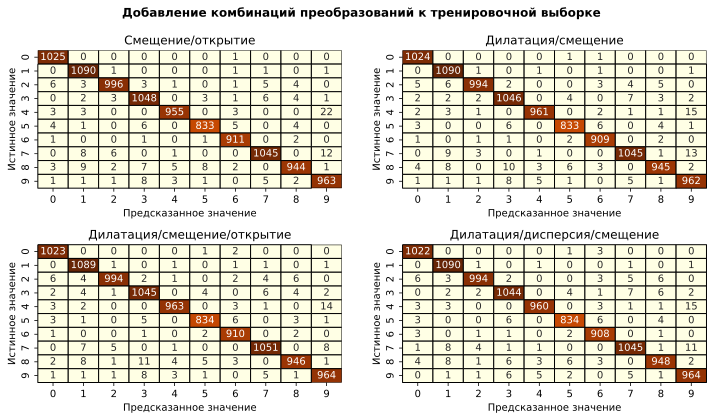

In [184]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
tit = ['Смещение/открытие', 'Дилатация/смещение', 'Дилатация/смещение/открытие', 'Дилатация/дисперсия/смещение']
arr_mat = [matrix_sh_op, matrix_dil_sh, matrix_dil_sh_op, matrix_dil_dis_sh]
plt.suptitle("Добавление комбинаций преобразований к тренировочной выборке", y=0.98, weight='bold')
for ax, m, t in zip(axes.flat, arr_mat, tit):
    sns.heatmap(m, cmap="YlOrBr", annot=True, fmt="g", ax=ax,
                 linewidths=1, linecolor='black',
                  cbar=False)
    ax.set_title(f'{t}')
    ax.set_ylabel('Истинное значение')
    ax.set_xlabel('Предсказанное значение')
plt.subplots_adjust(hspace = 0.41)
plt.savefig('ex5_all_combinash.pdf', format='pdf')
plt.show()

## ЭКСПЕРИМЕНТ 6

Реализуйте описанный выше алгоритм, основанный на преобразовании объектов тестовой выборки. Проверьте то же самое множество параметров, что и в предыдущем пункте. Проанализируйте как изменилась матрица ошибок, какие ошибки алгоритма помогает исправить каждое преобразование. Качественно сравните два подхода (5 и 6 пункты) между собой.


In [43]:
model = KNNClassifier(k=4, strategy='brute', metric='cosine', weights=True, test_block_size=1000)
model.fit(X_train, y_train)

In [44]:
y_pred_rot_5 = model.predict(rotation(X_test, 5))
y_pred_rot_10 =  model.predict(rotation(X_test, 10))
y_pred_rot_15 =  model.predict(rotation(X_test, 15))

y_pred_sh_1 = model.predict(shifted(X_test, 1))
y_pred_sh_2 = model.predict(shifted(X_test, 2))
y_pred_sh_3 = model.predict(shifted(X_test, 3))

y_pred_gaus_05 = model.predict(gaus(X_test, 7, 0.5))
y_pred_gaus_1 = model.predict(gaus(X_test, 9, 1))
y_pred_gaus_15 = model.predict(gaus(X_test, 11, 1.5))

y_pred_eros = model.predict(erosion(X_test))
y_pred_dis = model.predict(dilation(X_test))
y_pred_op = model.predict(opening(X_test))
y_pred_cl = model.predict(closing(X_test))

In [45]:
def temp_func(x):
    return np.argmax(np.bincount(x))

In [46]:
y_pred_full = np.vstack((y_pred_rot_5, y_pred_rot_10, y_pred_rot_15,
                        y_pred_sh_1, y_pred_sh_2, y_pred_sh_3,
                        y_pred_gaus_05, y_pred_gaus_1, y_pred_gaus_15,
                        y_pred_eros, y_pred_dis, y_pred_op, y_pred_cl))
y_pred_full = np.apply_along_axis(temp_func, 0, y_pred_full)

In [47]:
from itertools import combinations
all_y = [y_pred_rot_5, y_pred_rot_10, y_pred_rot_15,
                        y_pred_sh_1, y_pred_sh_2, y_pred_sh_3,
                        y_pred_gaus_05, y_pred_gaus_1, y_pred_gaus_15,
                        y_pred_eros, y_pred_dis, y_pred_op, y_pred_cl]
name = ['rot_5', 'rot_10', 'rot_15', 'sh_1', 'sh_2', 'sh_3', 
            'gaus_05', 'gaus_1', 'gaus_15', 'er', 'dis', 'op', 'cl']

all_combinations = []
all_name = []
for i in range (1, len(all_y) + 1):
    all_combinations.extend(combinations(all_y, i))
    all_name.extend(combinations(name, i))
                    
accur = []
for elem in all_combinations:
    temp = np.vstack(elem)
    temp = np.apply_along_axis(temp_func, 0, temp)
    accur.append(accuracy(temp, y_test))

In [48]:
a = np.array(accur)
indices = np.argsort(-a)
a = a[indices]
print("Набор 1", a[0], all_name[indices[0]])
print("Набор 2", a[1], all_name[indices[1]])
print("Набор 3", a[2], all_name[indices[2]])

Набор 1 0.9781 ('sh_1', 'sh_2', 'sh_3', 'gaus_05', 'gaus_1', 'er', 'dis')
Набор 2 0.978 ('sh_2', 'gaus_05', 'gaus_1', 'er')
Набор 3 0.9778 ('sh_1', 'sh_2', 'gaus_05', 'gaus_1', 'er', 'dis')


In [49]:
y_pred_2 = np.vstack((y_pred_sh_3, y_pred_gaus_05, y_pred_gaus_1, y_pred_eros))
y_pred_2 = np.apply_along_axis(temp_func, 0, y_pred_2)

y_pred_3 = np.vstack((y_pred_sh_2, y_pred_gaus_05, y_pred_gaus_1, y_pred_eros))
y_pred_3 = np.apply_along_axis(temp_func, 0, y_pred_3)

y_pred_4 = np.vstack((y_pred_sh_1, y_pred_sh_2, y_pred_sh_3,
                        y_pred_gaus_05, y_pred_gaus_1,
                        y_pred_eros, y_pred_dis))
y_pred_4 = np.apply_along_axis(temp_func, 0, y_pred_4)

Все преобразования: точность = 0.9748
Набор 1: точность = 0.9775
Набор 2: точность = 0.978
Набор 3: точность = 0.9781


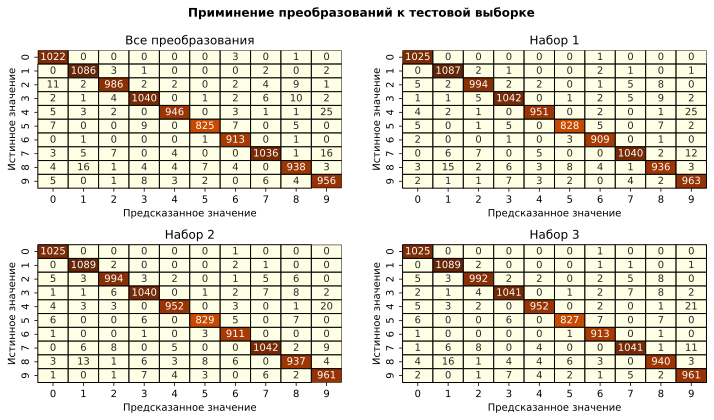

In [149]:
fig, axes = plt.subplots(2, 2, figsize=(12,6))
tit = ['Все преобразования', 'Набор 1', 'Набор 2', 'Набор 3']
arr_y = [y_pred_full, y_pred_2, y_pred_3, y_pred_4]
plt.suptitle("Приминение преобразований к тестовой выборке", y=0.98, weight='bold')
for ax, y, t in zip(axes.flat, arr_y, tit):
    acc = accuracy(y, y_test)
    print(f"{t}: точность = {acc}")
    
    matrix = confusion_matrix(y_test, y)
    sns.heatmap(matrix, cmap="YlOrBr", annot=True, fmt="g", ax=ax,
                 linewidths=1, linecolor='black',
                  cbar=False)
    ax.set_title(f'{t}')
    ax.set_ylabel('Истинное значение')
    ax.set_xlabel('Предсказанное значение')
plt.subplots_adjust(hspace = 0.41)
plt.savefig('ex6_all.pdf', format='pdf')
plt.show()